# Mecari Price Suggestion Challenge
- 일본의 대형 온라인 쇼핑몰인 Mercari사의 제품에 대해 가격을 예측하기 https://www.mercari.com/
- 제품 예상 가격을판매자들에게 제공하고자 함
- 판매자가 입력하는 제품명, 브랜드명, 카테고리, 제품설명 등의 텍스트 데이터
- https://youtu.be/Um1e6psCj_o


dataset: www.kaggle.com/c/mercari-price-suggestion-challenge/data

- train.tsv 파일


1.   train_id: 데이터 id (integer) - 일련번호로 매겨졌으므로 NaN데이터 없음
2.   name: 제품명 (string)
3. item_condition_id: 판매자가 제공하는 제품 상태 (integer levels, 1이면 new, 5이면 상태가 안 좋은 것)
4. category_name: 카테고리 명 (string)
5. brand_name: 브랜드 이름 (string, NaN이 포함됨)
6. shipping: 배송비 무료 여부. 1이면 무료(판매자가 지불), 0이면 유료(구매자가 지불) (binary)
7. item_description: 제품에 대한 설명 (string, 설명이 없는 것은 'No description yet'이라고 기록됨)
8. price: 제품 가격. 예측을 위한 타깃 속성 (float)


*item_description과 같은 텍스트 형태의 비정형 데이터와 다른 정형 속성을 같이 적용해 회귀를 수행함*


의견1) 배송료도 구매를 결정하는데 중요한 역할을 하는데, 단순히 유료배송이냐 무료배송이냐만 있다. 본인은 배송료까지 포함된 금액을 물건 가격으로 보고 구매를 결정함.

의견2) 이미지 정보는 포함되어 있지 않지만, 이미지 역시 가격을 측정하는데 중요한 역할을 함


필요한 경우 구글드라이브 마운트

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## import

In [2]:
import pandas as pd
import numpy as np

In [3]:
from sklearn.linear_model import Ridge , LogisticRegression
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer

## 데이터 불러오기

In [4]:
data_path = '/content/drive/My Drive/mercari/'
mercari_df= pd.read_csv(data_path+'train.tsv',sep='\t')

## 데이터 살펴보기(전처리)

In [5]:
print(mercari_df.shape)
mercari_df.head(3)

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [6]:
mercari_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


In [7]:
mercari_df.isnull().sum()[mercari_df.isnull().sum()>0]

# category_name은 약 6300건이 null
# brand_name의 경우 가격에 영향을 미치는 주요 요인임에도 null이 무척 많다.
# item_description은 4건이 null ==> 적절한 문자열로 치환해주자.

category_name         6327
brand_name          632682
item_description         4
dtype: int64

In [8]:
np.round(mercari_df.describe(), 2)

# 가격이 낮은 가격에 치우쳐있다(strongly left-skewed)
# 75% 이상이 30달러 이하의 상품
# 최소값은 0이라고 나온다.

,train_id,item_condition_id,price,shipping
count,1482535.00,1482535.00,1482535.00,1482535.00
mean,741267.00,1.91,26.74,0.45
std,427971.14,0.90,38.59,0.50
min,0.00,1.00,0.00,0.00
25%,370633.50,1.00,10.00,0.00
50%,741267.00,2.00,17.00,0.00
75%,1111900.50,3.00,29.00,1.00
max,1482534.00,5.00,2009.00,1.00


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


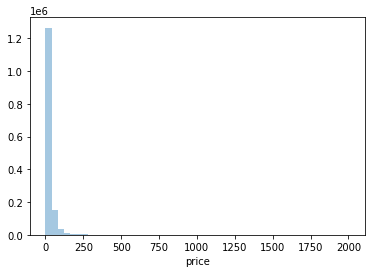

In [9]:
# 가격의 분포도

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

y_train_df = mercari_df['price']
plt.figure(figsize=(6,4))
sns.distplot(y_train_df, kde=False)

# 회귀에서 target값(여기서는 price)의 정규분포도는 매우 중요하다.

In [10]:
# 가격이 0원인 것이 어떤 것들인지 살펴보자
zero = mercari_df.loc[mercari_df['price'] == 0]
zero.head(10)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
1325,1325,Alabama Crimson Tide Quality Lanyard,1,Sports & Outdoors/Fan Shop/NCAA,NaN,0.0,1,TOP QUALITY THICK LANYARD Reversible sides wit...
2544,2544,Levi leggings,3,"Women/Jeans/Slim, Skinny",Levi's®,0.0,0,Light wash. Hardly worn. Size 24 but fits like...
2712,2712,Simple Red Lace Lingerie Top,3,Women/Underwear/G-Strings & Thongs,NaN,0.0,0,"Very simple but cute, a little form fitting as..."
3576,3576,Turquoise 15 Pc Makeup Brush Set,1,Beauty/Tools & Accessories/Makeup Brushes & Tools,NaN,0.0,1,1 left!
3761,3761,Girls size 7/8,3,Kids/Girls (4+)/Tops & T-Shirts,NaN,0.0,1,5 pair gap jean excellent used condition 3 chi...
5237,5237,Nursing Bra,3,Women/Underwear/Bras,Motherhood Maternity,0.0,0,Used a few times but was not able to nurse
6175,6175,"Multi Listing Bundled Package, Thanks",2,Electronics/Media/DVD,NaN,0.0,1,1)Large Collection of Full Length Strawberry S...
7116,7116,Nike Dri-Fit High Power Speed Tights,1,"Women/Athletic Apparel/Pants, Tights, Leggings",Nike,0.0,1,"Bought at Nike store in New York, Brand New, N..."
7622,7622,Hands free earpiece,1,Electronics/Cell Phones & Accessories/Headsets,NaN,0.0,0,Wireless Bluetooth hands free used with Samsun...
10812,10812,Vampire candy bowl,1,Home/Seasonal Décor/Halloween,NaN,0.0,0,New good condition for halloween


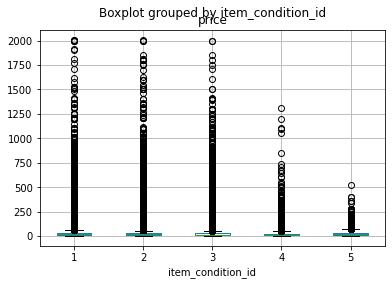

In [11]:
# 가격이 뭔가 이상하다. 가격과 다른 것들과의 관계를 살펴보자.
# price와 item_condition_id의 관계 살펴보기

mercari_df.boxplot('price', by='item_condition_id')

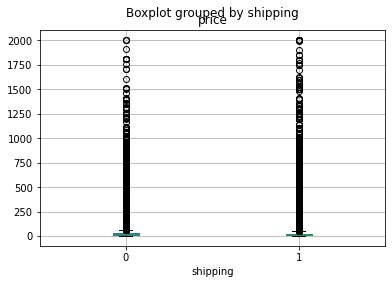

In [12]:
# price와 shipping의 관계 살펴보기

mercari_df.boxplot('price', by='shipping')

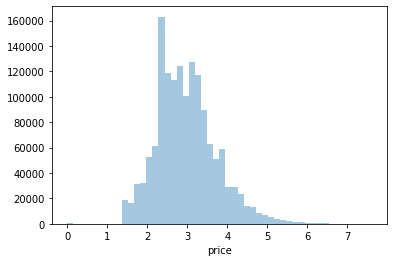

In [13]:
# price값이 비교적 적은 가격을 가진 데이터 값에 왜곡되어 분포되어 있으므로
# price칼럼을 로그값으로 변환한 뒤 분포도 살펴보기 ==> 비교적 정규분포에 가깝게 됨

y_train_df = np.log1p(y_train_df)
sns.distplot(y_train_df,kde=False)

In [14]:
# price를 로그값으로 변환하니 정규분포에 가깝게 되었다.
# ==> 데이터세트의 price 칼럼 값을 로그된 값으로 변환한다. log(p+1)
# mercari_df['log_price'] = np.log(mercari_df['price'] + 1)
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

0    2.397895
1    3.970292
2    2.397895
Name: price, dtype: float64

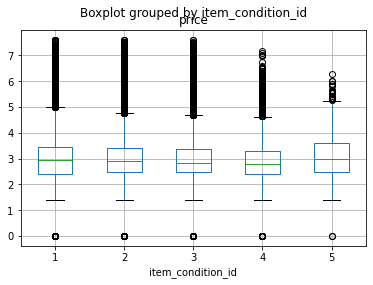

In [15]:
mercari_df.boxplot('price', by='item_condition_id')

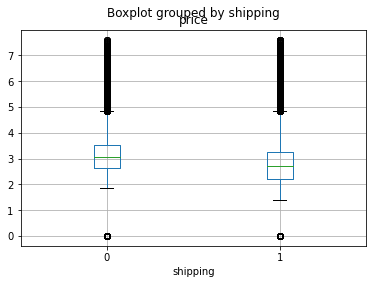

In [16]:
mercari_df.boxplot('price', by='shipping')

위 차트로 봤을 때는 condition이나 shipping이 price에 영항을 미치는 것 같지는 않다.

- https://www.kaggle.com/huguera/mercari-data-analysis/notebook

- https://www.kaggle.com/jparajuli/mercari-price-suggestion-preliminary-analysis/notebook

In [17]:
print(f"Shipping 값 유형:\n{mercari_df['shipping'].value_counts()}")

# 배송비의 유무. 비교적 균일

Shipping 값 유형:
0    819435
1    663100
Name: shipping, dtype: int64


In [18]:
print(f"item_condition_id 값 유형:\n{mercari_df['item_condition_id'].value_counts()}")

# 판매자가 제공하는 제품 상태는 주로 1,2,3이다.

item_condition_id 값 유형:
1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64


In [ ]:
boolean_cond= mercari_df['item_description']=='No description yet'
mercari_df[boolean_cond]['item_description'].count()

# item_description이 'No description yes'이라고 써있는 것의 개수는 82,489개
# 이 값은 Null과 마찬가지로 의미 없는 속성값이다 ==> 적절한 값으로 변경해야 함

82489

In [19]:
# category_name은 'Men/Tops/T-shirts' 형태로 됨
# 여기서 Men은 대, Tops은 중, T-shirts는 소
# 이 대, 중, 소를 별도의 feature로 저장해서 학습하자.

# apply lambda에서 호출되는 대,중,소 분할 함수 생성, 대,중,소 값을 리스트로 반환함
# category_name이 없는 것은 대.중.소 모두 'Other_Null'이 반환됨(약 6,300건)
def split_cat(category_name):
    try:
        return category_name.split('/')
    except:
        return ['Other_Null', 'Other_Null', 'Other_Null']

# 위의 split_cat( )을 호출하여 대,중,소 컬럼을 mercari_df에 생성. 
mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so'] = \
                        zip(*mercari_df['category_name'].apply(lambda x : split_cat(x)))

In [20]:
# 대분류만 값의 유형과 건수를 살펴보고, 중분류, 소분류는 값의 유형이 많으므로 분류 갯수만 추출
print('대분류 유형 :\n', mercari_df['cat_dae'].value_counts())
print('\n중분류 갯수 :', mercari_df['cat_jung'].nunique())    # unique한 value의 개수를 나타냄
print('소분류 갯수 :', mercari_df['cat_so'].nunique())

# ==> 대,중,소 분류도 one-hot-encoding 할 예정

대분류 유형 :
 Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: cat_dae, dtype: int64

중분류 갯수 : 114
소분류 갯수 : 871


In [ ]:
mercari_df.head(3)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,cat_dae,cat_jung,cat_so
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,2.397895,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,3.970292,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,2.397895,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse


In [21]:
# brand_name, category_name, item_description에 Null이 있는 경우에는 모두 'Other Null'로 변경
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value='Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value='Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value='Other_Null')

# 각 컬럼별로 Null값 건수 확인
mercari_df.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
cat_dae              0
cat_jung             0
cat_so               0
dtype: int64

## 피처 인코딩과 피처 벡터화
- 칼럼을 숫자형 코드값으로 인코딩
- 텍스트형 칼럼일 경우에는 피처 벡터화 변환

### brand name - LabelBinarizer(), 원핫인코딩
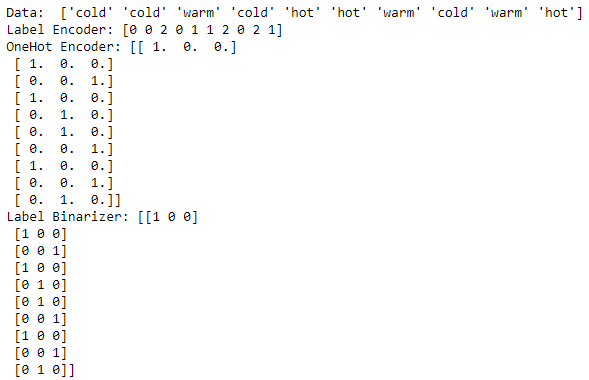

In [22]:
print('brand name 의 유형 건수 :', mercari_df['brand_name'].nunique())
print('brand name sample 5건 : \n', mercari_df['brand_name'].value_counts()[:5])

# Name: brand_name, dtype: int64
# brand_name의 경우 종류가 4810 건이지만 one-hot-encoding을 한다.(ML 모델 축에 큰 무리가 없다.)

brand name 의 유형 건수 : 4810
brand name sample 5건 : 
 Other_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: brand_name, dtype: int64


### name과 item_description을 피처 벡터화
- name : CountVectorizer()
- item_description : TfidfVectorizer()

==> 희소행렬 반환

- Tokenization: splitting text into words
- Stemming: removing word inflections (getting the root word)
- Vectorization: reducing text to a vector with frequencies for each word

CountVectorizer
: 단어들의 카운트(출현 빈도(frequency))로 여러 문서들을 벡터화. Returns an encoded vector with integer count for each word

- 카운트 행렬, 단어 문서 행렬 (Term-Document Matrix, TDM))
- 모두 소문자로 변환시키기 때문에 me 와 Me 는 모두 같은 특성이 된다.

TfidfVectorizer(term-frequency times inverse documentation-frequency): Returns an encoded vector with weighted count for each word

### name - CountVectorizer()

In [ ]:
print('name 의 종류 갯수 :', mercari_df['name'].nunique())
print('name sample 7건 : \n', mercari_df['name'][:7])

# name의 경우 종류가 1,225,273 건.
# 개별적으로 거의 고유한 상품명을 가지고 있다.
# 유형이 매우 많고, 적은 단어 위주의 텍스트 형태로 되어 있음
# ==> Count 기반으로 피처 백터화 변환 적용

name 의 종류 갯수 : 1225273
name sample 7건 : 
 0    MLB Cincinnati Reds T Shirt Size XL
1       Razer BlackWidow Chroma Keyboard
2                         AVA-VIV Blouse
3                  Leather Horse Statues
4                   24K GOLD plated rose
5       Bundled items requested for Ruie
6     Acacia pacific tides santorini top
Name: name, dtype: object


### item_description - TfidfVectorizer()

In [23]:
pd.set_option('max_colwidth', 200)

# item_description의 평균 문자열 개수
# 평균 문자열이 145자로 비교적 크므로 TF-IDF로 변환
print('item_description 평균 문자열 개수:',mercari_df['item_description'].str.len().mean())

mercari_df['item_description'][:2]

item_description 평균 문자열 개수: 145.7113889385411


0                                                                                                                                                                              No description yet
1    This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
Name: item_description, dtype: object

In [ ]:
# name 속성에 대한 feature vectorization 변환
cnt_vec = CountVectorizer()
X_name = cnt_vec.fit_transform(mercari_df.name)

# item_description 에 대한 feature vectorization 변환 
tfidf_descp = TfidfVectorizer(max_features = 50000, ngram_range= (1,3) , stop_words='english')
X_descp = tfidf_descp.fit_transform(mercari_df['item_description'])

print('name vectorization shape:',X_name.shape)
print('item_description vectorization shape:',X_descp.shape)

name vectorization shape: (1482535, 105757)
item_description vectorization shape: (1482535, 50000)


* stop_words에 대해 참고: https://wikidocs.net/22530

- brand_name : LabelNinarizer() - 'sparse_out = True'로 설정하면 희소 행렬 형태의 원-핫 인코딩 변환을 지원한다. 
- item_condition_id : LabelNinarizer()
- shipping : LabelNinarizer()
- cat_dae, cat_jung, cat_so : LabelNinarizer()

### brand_name, item_condition_id, shipping, category(dae, jung, so) - LabelBinarizer()

In [ ]:
# 이 부분은 수행 시간이 오래 걸린다.

from sklearn.preprocessing import LabelBinarizer

# brand_name, item_condition_id(1~5, 5가지 유형), shipping(0 or 1, 2가지 유형) 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_brand_name= LabelBinarizer(sparse_output=True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])

lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])

lb_shipping= LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

# cat_dae, cat_jung, cat_so 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_cat_dae = LabelBinarizer(sparse_output=True)
X_cat_dae= lb_cat_dae.fit_transform(mercari_df['cat_dae'])

lb_cat_jung = LabelBinarizer(sparse_output=True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])

lb_cat_so = LabelBinarizer(sparse_output=True)
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])

In [ ]:
print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print('X_brand_shape:{0}, X_item_cond_id shape:{1}'.format(X_brand.shape, X_item_cond_id.shape))
print('X_shipping shape:{0}, X_cat_dae shape:{1}'.format(X_shipping.shape, X_cat_dae.shape))
print('X_cat_jung shape:{0}, X_cat_so shape:{1}'.format(X_cat_jung.shape, X_cat_so.shape))

# X_brand_shape은 칼럼이 4810개, X_cat_so도 칼럼이 871개
# 피처 벡터화로 텍스트 형태의 문자열이 가지는 벡터 형태의 매우 많은 칼럼과 함께 결합되므로 크게 문제되지 않는다.

<class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'>
X_brand_shape:(1482535, 4810), X_item_cond_id shape:(1482535, 5)
X_shipping shape:(1482535, 1), X_cat_dae shape:(1482535, 11)
X_cat_jung shape:(1482535, 114), X_cat_so shape:(1482535, 871)


In [ ]:
from  scipy.sparse import hstack
import gc

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id,
            X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

# scipy sparse 모듈의 hstack 함수를 이용하여 앞에서 인코딩과 Vectorization을 수행한 데이터 셋을 모두 결합. 
# csr : Compressed sparse row 
X_features_sparse= hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)

# 데이터 셋이 메모리를 많이 차지하므로 사용 용도가 끝났으면 바로 메모리에서 삭제. 
# 나중에 필요할 때마다 다시 결합해서 사용한다.
del X_features_sparse
gc.collect()    # garbage collection. 인자가 없을 경우 '전체 수거'

<class 'scipy.sparse.csr.csr_matrix'> (1482535, 161569)


62

## 릿지 회귀 모델 구축 및 평가
- 영향을 거의 미치지 않는 특성에 대하여 0에 가까운 가중치를 주는 방법

In [ ]:
def rmsle(y , y_pred):
    # underflow, overflow를 막기 위해 log가 아닌 log1p로 rmsle 계산 
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

def evaluate_org_price(y_test , preds): 
    
    # 원본 데이터는 log1p로 변환되었으므로 exmpm1으로 원복 필요. 
    preds_exmpm = np.expm1(preds)
    y_test_exmpm = np.expm1(y_test)
    
    # rmsle로 RMSLE(Root Mean Square Logarithmic Error) 값 추출
    rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
    return rmsle_result

In [ ]:
import gc 
from  scipy.sparse import hstack

def model_train_predict(model,matrix_list):
    # scipy.sparse 모듈의 hstack 을 이용하여 sparse matrix 결합
    X= hstack(matrix_list).tocsr()     
    
    X_train, X_test, y_train, y_test=train_test_split(X, mercari_df['price'], 
                                                      test_size=0.2, random_state=156)
    
    # 모델 학습 및 예측
    model.fit(X_train , y_train)
    preds = model.predict(X_test)
    
    del X , X_train , X_test , y_train 
    gc.collect()
    
    return preds , y_test

In [ ]:
linear_model = Ridge(solver = "lsqr", fit_intercept=False)

sparse_matrix_list = (X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds , y_test = model_train_predict(model=linear_model ,matrix_list=sparse_matrix_list)
print('Item Description을 제외했을 때 rmsle 값:', evaluate_org_price(y_test , linear_preds))

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds , y_test = model_train_predict(model=linear_model , matrix_list=sparse_matrix_list)
print('Item Description을 포함한 rmsle 값:',  evaluate_org_price(y_test ,linear_preds))

Item Description을 제외했을 때 rmsle 값: 0.5023727038010544
Item Description을 포함한 rmsle 값: 0.4712195143433641


## LightGBM 회귀 모델 구축과 앙상블을 이용한 최종 예측 평가
- 레벨을 확장하는 게 아니라, 리프(leaf)를 확장한다.
- 빠르다. 학습 시간 단축됨
- 메모리를 적게 쓴다.
- max_depth를 조절할 수 있다. (overfitting에 민감)

* 참고: https://nurilee.com/lightgbm-definition-parameter-tuning/

In [ ]:
from lightgbm import LGBMRegressor

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

# n_estinators를 조절해보자.(200~)
lgbm_model = LGBMRegressor(n_estimators=200, learning_rate=0.5, num_leaves=125, random_state=156)
lgbm_preds , y_test = model_train_predict(model = lgbm_model , matrix_list=sparse_matrix_list)
print('LightGBM rmsle 값:',  evaluate_org_price(y_test , lgbm_preds))

LightGBM rmsle 값: 0.45719580244261243


In [ ]:
preds = lgbm_preds * 0.45 + linear_preds * 0.55
print('LightGBM과 Ridge를 ensemble한 최종 rmsle 값:',  evaluate_org_price(y_test , preds))

LightGBM과 Ridge를 ensemble한 최종 rmsle 값: 0.4507259214329315
